# Simple 2D Bayesian Optimisation over smb for the East Antarctic Plateau

This notebook is created to showcase a simple application of Bayesian Optimisation (BO) to smb data.

Objective: 
Find location with minimum smb (surface mass balance, average over 18 years) over the East Antarctic Plateau. 

## Data

- RACMO2.3p3 ANT27 data
    - key publication [van Dalum et al. 2022](10.5194/egusphere-egu22-12543)
    - data on zenodo [link](https://zenodo.org/record/5512077#.Y-BERuxBwvo), CON stands for Control run
        - file: `smb_monthlyS_ANT27_CONsettings_197901_201812.nc`
    - overview of model versions and meta data on [Institute for Marine and Atmospheric research Utrecht (IMAU) website](https://www.projects.science.uu.nl/iceclimate/models/racmo-data.php)
    - description of model updates on [website](https://www.projects.science.uu.nl/iceclimate/models/racmo-model.php#1-2)
        
- Previous version: RACMO2.3p2 ANT27 data 
     - data on [Utrecht University server](https://www.projects.science.uu.nl/iceclimate/publications/data/2018/vwessem2018_tc/RACMO_Yearly/)
     - I requested 2 km downscaled smb data from RACMO2.3p2 (stereographic projection) from [Dr Brice Noël](https://scholar.google.be/citations?user=MnrZh5wAAAAJ&hl=en)

### Units
Surface Mass Balance (SMB) in units of millimeters of water equivalent (w.e.) per year. The unit is the same as kg m^(–2). 

### Projection
- The smb data is provided using Rotated Pole projection. 
- I am using [EPSG:3031](https://epsg.io/3031) WGS 84 / Antarctic Polar Stereographic projection because this is the standard for Antarctic data.

In [144]:
import xarray as xr
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.colors as colors

# cartopy: Coordinate Reference System (list of projections)
import cartopy
# common abbreviation
import cartopy.crs as ccrs
import cartopy.feature as cfe

# Projections between CRSs (Coordinate Reference Systems)
import pyproj
import shapely
from pyproj import Proj, transform

import gpytorch
import torch
import GPy 

from botorch.models import SingleTaskGP, ModelListGP
# Gpytorch is a dependency of BoTorch
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.optim import optimize_acqf

# Inline interactive vis properties in Jupyter lab
%matplotlib ipympl
%matplotlib inline

import watermark

## Load data

In [124]:
# change this to your path
full_path = "/Users/kimbente/Desktop/Bayesian Optimisation/BO-ANT-project/raw-data/RACMO2.3p3/CON_data/smb_monthlyS_ANT27_CONsettings_197901_201812.nc"

ds = xr.open_dataset(full_path)

## Preprocess

In [129]:
# PREPROCESSING IN XARRAY
def preprocess_racmo_xr(dataset_xr):
    """
    """
    # remove height as dimension and as coordinate because it is redundant
    dataset_xr_clean = dataset_xr.drop_vars('height').squeeze()
    # extract smb variable and take mean over all available years
    # type needs to be xarray.Dataset to have explicit dimensions
    dataset_smb_xr = dataset_xr_clean["smb"].mean("time").to_dataset()
    
    # PROJECTION
    # define projection from rotated pole to APS
    # always x y or lon lat order
    rotatedpole_to_APS71_func = pyproj.Transformer.from_crs(crs_from = pyproj.CRS("-m 57.295779506 +proj=ob_tran +o_proj=latlon +o_lat_p=-180.0 +lon_0=10.0"),  
                                                  crs_to = pyproj.CRS("+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs"), 
                                                  always_xy = True)
    # create meshgrid from rotated_pole grid
    rlon_2d, rlat_2d = np.meshgrid(dataset_smb_xr.rlon.values, dataset_smb_xr.rlat.values)
    # transform points
    x_2d, y_2d = rotatedpole_to_APS71_func.transform(rlon_2d, rlat_2d)
    # add as coordinates to to xarray
    dataset_smb_xr.coords['x_2d'] = (dataset_smb_xr.coords["lat"].dims, x_2d)
    dataset_smb_xr.coords['y_2d'] = (dataset_smb_xr.coords["lon"].dims, y_2d)
    
    return dataset_smb_xr

# call xarray preprocessing function
ds_xr_processed = preprocess_racmo_xr(ds)

In [130]:
# CREATE DATAFRAME
# extract flattend pairs of xy coordinates
xy_pairs = np.array([ds_xr_processed.coords['x_2d'].values, ds_xr_processed.coords['y_2d'].values]).reshape(2,-1)

# create pandas DataFrame
df = pd.DataFrame(data = {'smb': ds_xr_processed.smb.values.reshape(-1),
                          # first column
                          'x': xy_pairs[0,:],
                          # second column
                          'y': xy_pairs[1,:],
                                        }
                                )

In [131]:
# Subset region to square in the East Antarctic Plateau
# min and max in APS projection
x_min = 600000
x_max = 1900000

y_min = -1000000
y_max = 300000

df_EAIS = df[df['x'].between(x_min, x_max) & df['y'].between(y_min, y_max)]

In [132]:
# Show area
def plot_APS(dataset, dataset_values):
    """
    """
    plt.figure(figsize = (10, 10))
    
    # Projection: target map; north is aligned with Greenwich (longitude), centred at South Pole
    ax = plt.subplot(projection = ccrs.Stereographic(central_longitude = 0., central_latitude = -90.))
    ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

    # set up a Cartopy coordinate reference system for the data (rotated pole as described above)
    data_crs = ccrs.Stereographic(central_longitude = 0., central_latitude = -90.)

    # Overlay of black coastline (built-in)
    ax.coastlines(resolution = '50m')

    # Add dots of data grid
    ax.scatter(x = x_min, y = y_min, c = "red", marker = "+", transform = data_crs)
    ax.scatter(x = x_min, y = y_max, c = "red", marker = "+", transform = data_crs)
    ax.scatter(x = x_max, y = y_min, c = "red", marker = "+", transform = data_crs)
    ax.scatter(x = x_max, y = y_max, c = "red", marker = "+", transform = data_crs)

    # softcoded
    ax.set_title("Selected area", size = 'xx-large')

    plt.show()

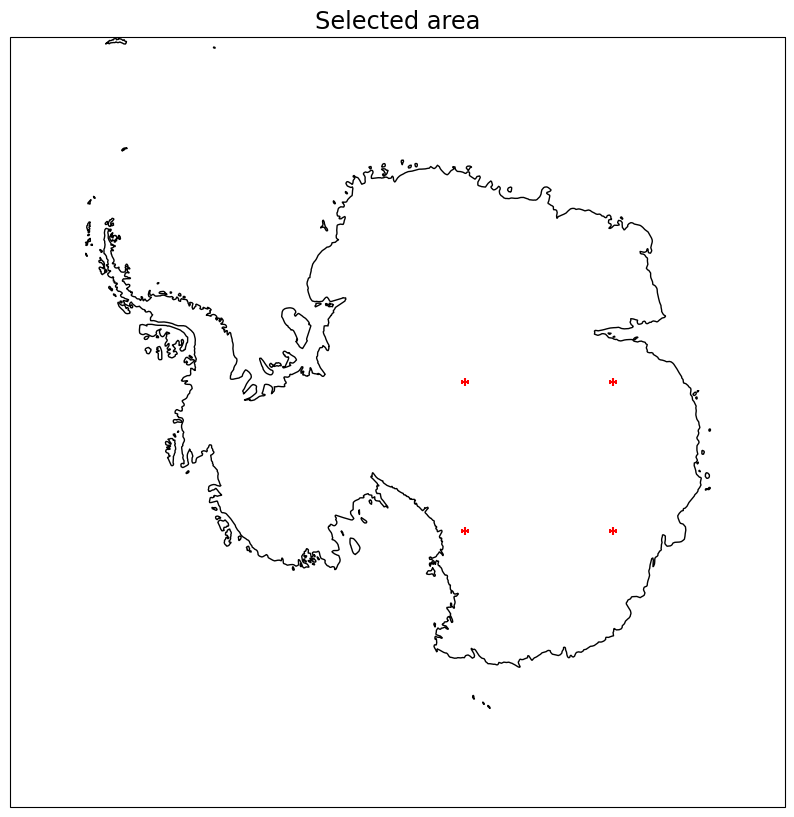

In [96]:
plot_APS(None, None)

# GP over smb

Since this is a simulated experiment, we assume access to the true smb function, based on data from the RACMO2.3p3 regional climate model (RCM). The data is given on a grid using a rotated pole projection. To optimise in the continous domain (where we can query anywhere) we use a GP to infer a continous, smooth target function. 

We will be using the (Antarctic) Polar Stereographic projection for visualisations and in a subsequent problem setting with additional input data, since this is the dominant projection used in Antarctic Sciences. 

Because we are using the BoTorch package for Bayeisan Optimisation, we will use Gpytorch.

In [133]:
# normalise coordinates with bounds
x1_norm = (df_EAIS.x.values - x_min)/(x_max - x_min)
x2_norm = (df_EAIS.y.values - y_min)/(y_max - y_min)

# transpose for shape: torch.Size([2238, 2])
train_x = torch.tensor(np.array([x1_norm, x2_norm]).T, dtype = torch.double)
train_y = torch.tensor(np.array(df_EAIS["smb"]), dtype = torch.double)

# test
x_range = x_max - x_min
y_range = y_max - y_min

x1_mesh, x2_mesh = np.meshgrid(np.linspace(0, 1, 51), np.linspace(0, 1, 51))
test_x = torch.tensor(np.array([x1_mesh.reshape(-1), x2_mesh.reshape(-1)]).T, dtype = torch.double)

In [134]:
np.where(test_x[:,0] == 0.)

(array([   0,   51,  102,  153,  204,  255,  306,  357,  408,  459,  510,
         561,  612,  663,  714,  765,  816,  867,  918,  969, 1020, 1071,
        1122, 1173, 1224, 1275, 1326, 1377, 1428, 1479, 1530, 1581, 1632,
        1683, 1734, 1785, 1836, 1887, 1938, 1989, 2040, 2091, 2142, 2193,
        2244, 2295, 2346, 2397, 2448, 2499, 2550]),)

In [135]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        # Try other kernels
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [138]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 100


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood, exact inference
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    # Negative marginal log likelihood
    loss = - mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/100 - Loss: -2.285   lengthscale: 0.201   noise: 0.000
Iter 2/100 - Loss: -2.283   lengthscale: 0.183   noise: 0.000
Iter 3/100 - Loss: -2.205   lengthscale: 0.193   noise: 0.000
Iter 4/100 - Loss: -2.218   lengthscale: 0.205   noise: 0.000
Iter 5/100 - Loss: -2.103   lengthscale: 0.212   noise: 0.000
Iter 6/100 - Loss: -2.202   lengthscale: 0.208   noise: 0.000
Iter 7/100 - Loss: -2.252   lengthscale: 0.201   noise: 0.000
Iter 8/100 - Loss: -2.236   lengthscale: 0.196   noise: 0.000
Iter 9/100 - Loss: -2.236   lengthscale: 0.193   noise: 0.000
Iter 10/100 - Loss: -2.203   lengthscale: 0.191   noise: 0.000
Iter 11/100 - Loss: -2.213   lengthscale: 0.188   noise: 0.000
Iter 12/100 - Loss: -2.196   lengthscale: 0.187   noise: 0.000
Iter 13/100 - Loss: -2.216   lengthscale: 0.187   noise: 0.000
Iter 14/100 - Loss: -2.222   lengthscale: 0.189   noise: 0.000
Iter 15/100 - Loss: -2.299   lengthscale: 0.193   noise: 0.000
Iter 16/100 - Loss: -2.261   lengthscale: 0.198   noise: 0.000
I

In [139]:
# Ensure eval mode
model.eval()
likelihood.eval()

# Small test for x == 0.
test_x_x0 = test_x[np.where(test_x[:,0] == 0.)]

f_preds_x0 = model(test_x_x0)
y_preds_x0 = likelihood(model(test_x_x0))

# Unpacking the predictions
f_mean_x0 = f_preds_x0.mean
f_var_x0 = f_preds_x0.variance
f_covar_x0 = f_preds_x0.covariance_matrix
# f_samples = f_preds.sample(sample_shape = torch.Size(100,))

# 2D visualisation

We are slicing through the 3D surface at x = 0 to visualise the GP regression.

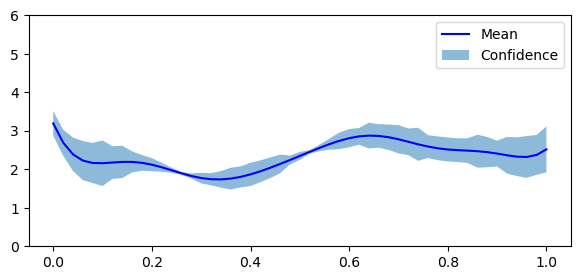

In [92]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize = (7, 3))

    # Get upper and lower confidence bounds
    lower, upper = y_preds_x0.confidence_region()
    
    # Plot predictive means as blue line
    # test_x_x0 is 2D so select second column only
    ax.plot(test_x_x0[:,1].numpy(), y_preds_x0.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x_x0[:,1].numpy(), lower.numpy(), upper.numpy(), alpha = 0.5)
    
    # observations are on different grid but just add 22 obs very close to x = 0 line
    # ax.plot(((df_EAIS.sort_values(by = ["x"], ascending = True)[0:22]["y"].values - y_min)/(y_max - y_min)), 
    #        df_EAIS.sort_values(by = ["x"], ascending = True)[0:22]["smb"].values, 'k*')
    
    ax.set_ylim([0, 6])
    ax.legend(['Mean', 'Confidence'])
    
    # add additional datapoints from model

# Interpolate at smooth grid

In [91]:
# Ensure eval mode
model.eval()
likelihood.eval()

f_preds = model(test_x)
y_preds = likelihood(model(test_x))

# Unpacking the predictions
f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
# f_samples = f_preds.sample(sample_shape = torch.Size(100,))

/Users/kimbente/opt/anaconda3/envs/py3.9/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(


# 3D visualisation

In [114]:
df_smb_grid = pd.DataFrame(data = {'smb_mean': f_mean.detach().numpy(), 
                     'smb_var': f_var.detach().numpy(), 
                     'x_norm': test_x[:,0].numpy(),
                     'y_norm': test_x[:,1].numpy(),
                    })

df_xy_matrix = df_smb_grid.pivot(index = 'x_norm', columns = 'y_norm', values = 'smb_mean')
x1_mesh, x2_mesh = np.meshgrid(df_xy_matrix.index, df_xy_matrix.columns)
y_mesh = np.array(df_xy_matrix)

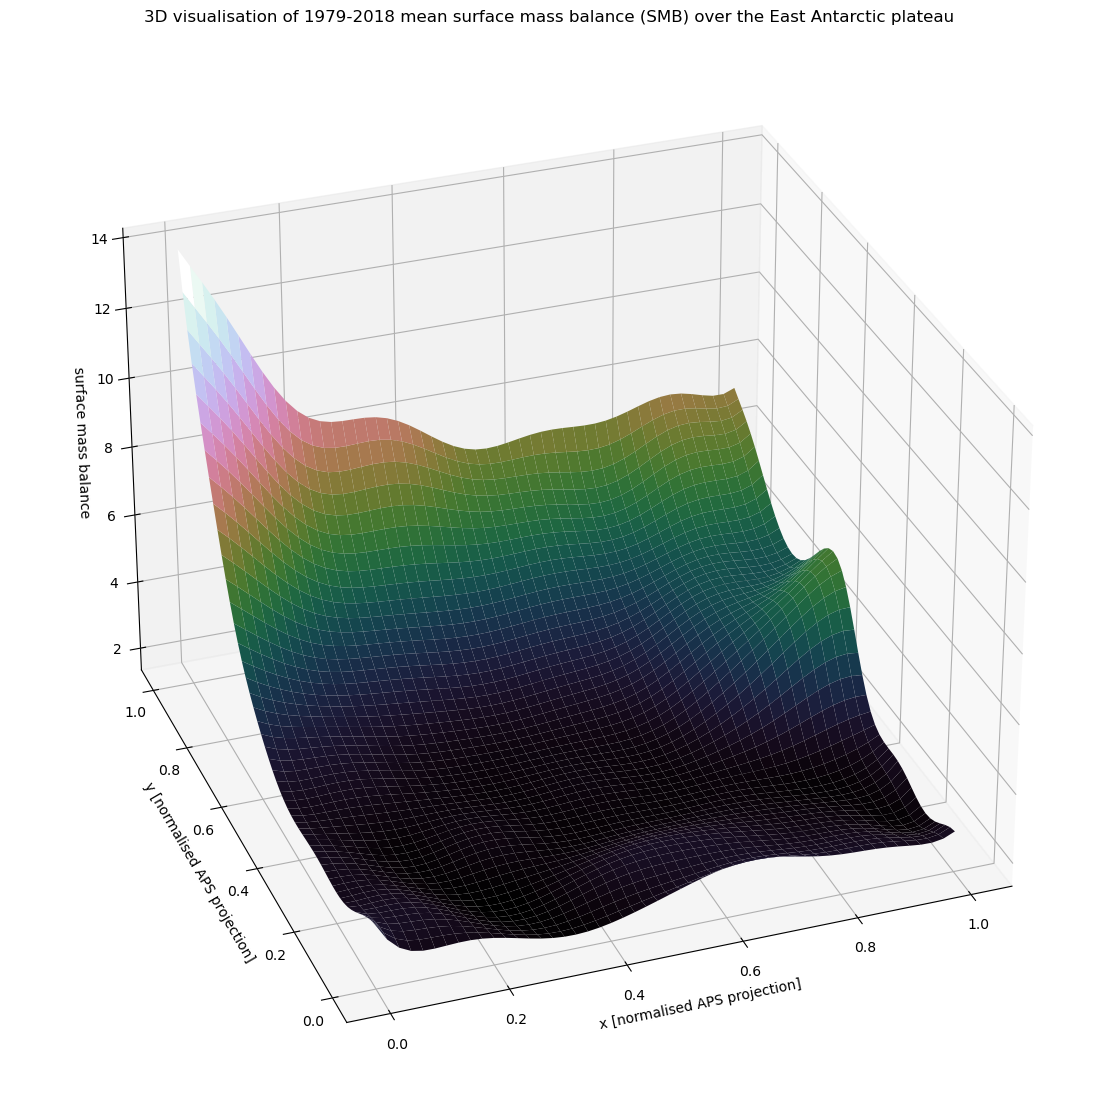

In [117]:
# 3D plot of mean smb
fig = plt.figure(figsize = (14, 14))
ax = plt.axes(projection = '3d') 
ax.plot_surface(x1_mesh, x2_mesh, y_mesh, rstride = 1, cstride = 1, cmap = 'cubehelix') 

ax.set_title("3D visualisation of 1979-2018 mean surface mass balance (SMB) over the East Antarctic plateau")
ax.set_xlabel('x [normalised APS projection]')
ax.set_ylabel('y [normalised APS projection]')
ax.set_zlabel('surface mass balance')

ax.view_init(elev = 30, azim = 250)

plt.show()

# Kernels

ToDo: Try non-stationary kernels like Gibbs or `Remes, Sami, Markus Heinonen, and Samuel Kaski. "Non-stationary spectral kernels." Advances in neural information processing systems 30 (2017).`

- [Kernels in GpyTorch](https://docs.gpytorch.ai/en/stable/kernels.html)
    - [GridInterpolationKernel](https://docs.gpytorch.ai/en/stable/kernels.html#gridinterpolationkernel)
    - [SpectralMixtureKernel](https://docs.gpytorch.ai/en/stable/kernels.html#spectralmixturekernel)
- [Kernels in PyMC3](https://pymc3-testing.readthedocs.io/en/rtd-docs/notebooks/GP-covariances.html)

# BO

In [ ]:
# noise-free target function
def target_function(query_locations):
    # takes in list of lists as torch.tensor
    
    # placeholder: empty array
    results = np.empty(0)
    for x in query_locations:
        # Append only mean of kernel (neglect variance) to results array
        # reshape(1, -1): 1 for only one row of x, -1 for remaining dimensions
        # * (-1) because we maximise
        results = np.append(results, (np.array(m.predict(np.array(x).reshape(1,-1))[0]).reshape(-1) * (-1)))
    return(torch.tensor(results))

In [ ]:
def generate_initial_data(n = 10):
    # Need unified dtypes
    train_x = torch.rand(n, 2, dtype = torch.float64) # n rows, 2 columns, sample between 0 and 1 (range)
    exact_obj = target_function(train_x).unsqueeze(-1)
    best_y = exact_obj.max()
    return train_x, exact_obj, best_y

In [ ]:
# function wrapper
def get_next_point(queried_X, queried_y, best_queried_y, bounds, n_points = 1):
    model = SingleTaskGP(queried_X, queried_y)
    # Pass in class liklihood for exact likelihood
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    
    EI = qExpectedImprovement(model = model, best_f = best_queried_y)
    
    candidates, _ = optimize_acqf(
                                acq_function = EI,
                                bounds = bounds,
                                q = n_points, # number of candidates returned
        
                                # HYPERS
                                num_restarts = 200,
                                raw_samples = 256,
                                options = {"batch_limit" : 5, "maxiter" : 200} 
    )
    return candidates

In [ ]:
# n_runs = 10
#
# Call to generate initial data
# queried_x, queried_y, best_queried_y = generate_initial_data(n = 15)
#
# bounds for inputs: x1 and x2 have been min-max normalised
# bounds = torch.tensor([[0.,0.],[1.,1.]])
#
# for i in range(n_runs):
#    print(f"Run number: {i}")
#    new_candidate = get_next_point(queried_x, queried_y, best_queried_y, bounds, n_points = 1)
#    new_result = target_function(new_candidate).unsqueeze(-1)
#    print(f"New candidate: {new_candidate}")
#    
#    # Update
#    queried_x = torch.cat([queried_x, new_candidate])
#    queried_y = torch.cat([queried_y, new_result])
#    
#    # Check 
#    best_queried_y = queried_y.max()
#    # Maximisation of neg smb to minimise
#    print(f"New best y (smb): {best_queried_y}")

## References

[APA citation style]

- van Dalum, C., van de Berg, W. J., & van den Broeke, M. (2022, May). Antarctic surface climate in RACMO2. 3p3. In EGU General Assembly Conference Abstracts (pp. EGU22-12543).

## Versions

In [145]:
# Python package versions used

%load_ext watermark
%watermark --python
%watermark --iversions

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.7.0

matplotlib: 3.6.2
pyproj    : 3.4.1
cartopy   : 0.21.1
watermark : 2.3.1
torch     : 1.13.1
numpy     : 1.23.5
pandas    : 1.5.2
gpytorch  : 1.9.1
shapely   : 2.0.0
xarray    : 2022.11.0

